## Final Project: House Prices Prediction
https://www.kaggle.com/c/house-prices-advanced-regression-techniques  

### Team MLAIRE: Chi Iong Ansjory, Prabhat Tripathi, Soodong Kim, Tina Agarwal

## Problem

The goal of this project is to predict sale price of residential homes in Ames, Iowa based on the given training and test data sets. There are 79 explanatory variables describing different aspects of residential homes with 1460 observations in both training and test data sets (this is different than previous class projects where train data is usually larger than test data set). 

The output variable (SalePrice) is quantitative (continuous) whereas the explanatory (LHS) variables are a combination of quantitative (continuous) and categorical variables. 

Considering the size and nature of the data set, and informed by our domain understanding, we beleive that *feature engineering* -- crafting data features optimized for machine learning -- is key for better modeling for this problem. Specifically, we plan to perform following:

- Univariate analysis of output and explanatory variables: weed out spurious or wrong values. Understand patterns and outliers for each variable. Allow for missing values (NaN) imputations.
- Transform categorical variables into numeric (using dummy variables?)
- Check if log transformation of output and explanatory variables helps better model performance
- Identify and remove unhelpful explanatory variables (using correlation matrix or using techniques such as LASSO)
- Identify and remove multicollinearity, if present
- Advance feature engineering techniques such as PCA?

We also have to watch out for overfitting considering there are a large number of input variables (compared to the training data size).

We plan to begin with (multiple) LinearRegression model (for speed) and if the accuracy is not satisfactory, we would try other models such as random forest and gradient-boosting tree. If needed, we may have to ensemble all these models for better overall accuracy. We will split test data into two random sets and use one as "dev" data during model buidling process.

## Data Loading

In [15]:
# Each plot will not open a new window. 
%matplotlib inline

# Import relevant libraries.

# General libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# Libraries for files
import os

# Python fundamental libraries
import collections

# Disable warnings for more clear output
import warnings 
warnings.filterwarnings('ignore')


### Define Own Libraries

In [16]:
# Define helper functions
def get_distinct_num(values):
    return len(set(values))

def print_distinct_num(data, col_name):
    if col_name in data.keys():
        print("Distinct variation of {} is {}".format(col_name, get_distinct_num(data[col_name])))
        
ColumnAndDefaultValue = collections.namedtuple('ColumnAndDefaultValue', ['col_name', 'default_value'])

def set_missing_value(data, filling_requests):
    for col_and_default_value in filling_requests:
        data[col_and_default_value.col_name] = data[col_and_default_value.col_name]\
            .fillna(col_and_default_value.default_value)

### Import Data

In [6]:
# Load Data

# Please keep this relative path access to data.
dir_name = os.getcwd()
train_filename = os.path.join(dir_name, 'data/train.csv')
test_filename = os.path.join(dir_name, 'data/test.csv')

# Reading the data
train = pd.read_csv(train_filename)
test  = pd.read_csv(test_filename)

# Look at the train data
train.info()

# Look at the test data
test.info()

print("\nThe train data shape is: {} ".format(train.shape)) 
print("\nThe test data shape is: {} ".format(test.shape))

train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Explanatory Data Analysis

### Feature Correlation

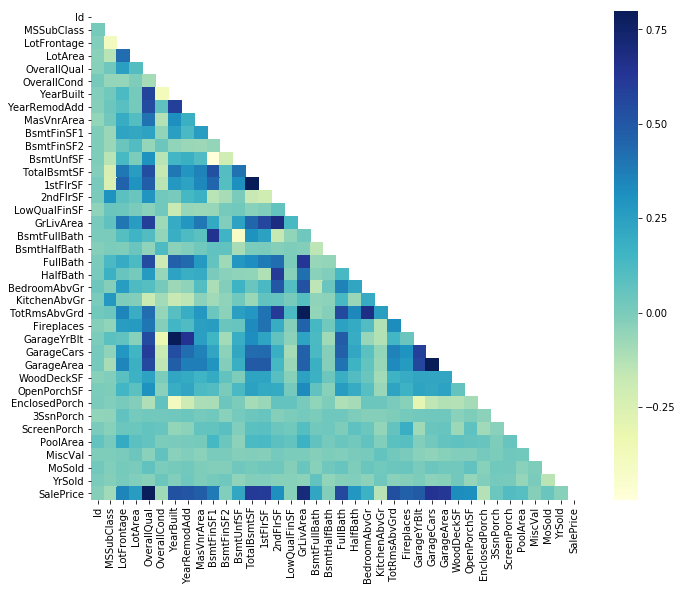

In [7]:
copied_train = train.copy()
copied_train = copied_train.drop(['Id'],axis=1,errors='raise') # Remove Id that is not relevant for corr analysis.
corr_matrix = copied_train.corr()
mask = np.zeros_like(corr_matrix) # Zero array with same shape of corr_matrix
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=0.8, square=True, cmap="YlGnBu", mask=mask)

### Univariate Analysis

Based on the correlation heatmap above, a few highly correlated variables are picked for further univariate analysis. Plotting histograms for various variables to see if it is normally distributed and if logarithmic transformation is needed as well. Same exercise will be performed on more variables.

Text(0,0.5,'Frequency')

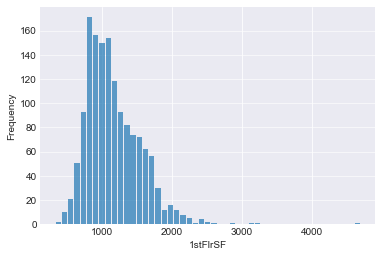

In [58]:
plt.hist(x=train['1stFlrSF'], bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('1stFlrSF')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

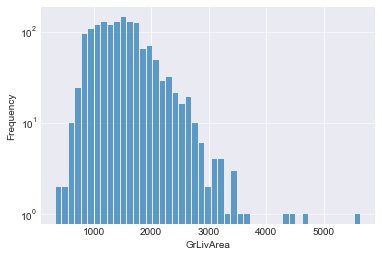

In [59]:
plt.hist(x=train['GrLivArea'], bins='auto', log=True, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('GrLivArea')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

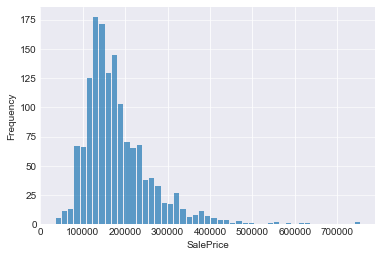

In [60]:
plt.hist(x=train['SalePrice'], bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

### Bivariate Analysis

In this section we will analyse relationship between output variable (SalePrice) and dependent variables to discriminate important predictor variables from spurious relationships. There are observable and potentially consistent outliers in both scatterplots below that we may need to perform further analysis on. Same exercise will be performed on more pairs of variables.

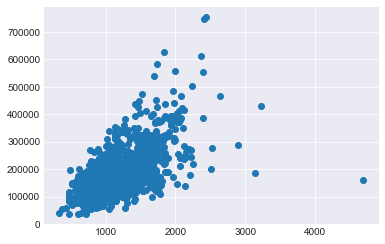

In [61]:
plt.scatter(x=train['1stFlrSF'], y=train['SalePrice'])

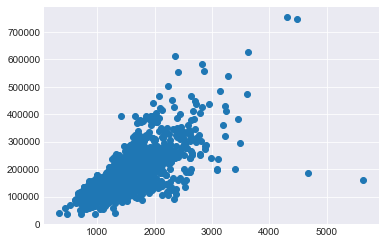

In [63]:
plt.scatter(x=train['GrLivArea'], y=train['SalePrice'])

### Missing Data Analysis

In [12]:
# Investigate about missing data
# Analyze top 15 columns having missing data

total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() / train.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat(
    [total, percent], axis=1, keys=["Total Number of Missing Data", "Missing Data Percentage"])
missing_data.head(15)

,Total Number of Missing Data,Missing Data Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


There are 4 fields whose missing data portion is larger than 50%. Missing data will be cleaned up in the follow-up section.

## Data Clean Up

### Drop LotFrontage and Utilities

Drop Lot Frontage since there is no reasonable information to fill missing values. Since it has 17.7% missing data percentage,
using this column can not help prediction. 

Drop Utilities as it does not sufficient prediction power since all values are dedicated to same value
"AllPub". For univariate analysis of "AllPub", please see above univariate section.

In [13]:
print_distinct_num(train, 'LotFrontage') # Distinct value number is 369.
print_distinct_num(train, 'Utilities') # Distinct value number is 2.

train = train.drop(['Utilities'],axis=1,errors='ignore')
train = train.drop(['LotFrontage'],axis=1,errors='ignore')

Distinct variation of LotFrontage is 369
Distinct variation of Utilities is 2


### Fill Missing Values

For string data columns, default value can be guessed from the documnation.
For non string data columns, zero or none can be assigned.

In [14]:
filling_requests = []
filling_requests.append(ColumnAndDefaultValue('PoolQC', 'No Pool'))
filling_requests.append(ColumnAndDefaultValue('MiscFeature', 'None'))
filling_requests.append(ColumnAndDefaultValue('Alley', 'None'))
filling_requests.append(ColumnAndDefaultValue('Fence', 'None'))
filling_requests.append(ColumnAndDefaultValue('FireplaceQu', 'None'))
filling_requests.append(ColumnAndDefaultValue('GarageCond', 'No Garage'))
filling_requests.append(ColumnAndDefaultValue('GarageType', 'No Garage'))
filling_requests.append(ColumnAndDefaultValue('GarageFinish', 'No Garage'))
filling_requests.append(ColumnAndDefaultValue('GarageQual', 'No Garage'))
filling_requests.append(ColumnAndDefaultValue('BsmtCond', 'No Basement'))
set_missing_value(train, filling_requests)

## Modeling

In this section, we plan to perform:
* Feature Engineering
* Dimentionality reduction
* Building and tuning home prices prediction models


From 79 available features (input variables), we will find statistically and practically significant variables for modeling. We also will try to watch out for collinearity and spurious relationships.  

We plan to start with LinearRegression model because of the predictive nature of the problem. We will also try other supervised learning models such as Random Forest and Gradient Boosting Tree if they increase accuracy.

We will be working on two broad sets of algorithms:
1. Linear Models
2. Non Linear relationships using Random Forests

#### Linear Models
For linear models, we will try and test with the regular OLS model, and the regularized linear models of Ridge Regression, Least Absolute Shrinkage and Selection Operator (LASSO), and Elastic Net. 

For model tuning, Sklearn's grid search with CV function will be used to find the optimal hyper-parameter values.

To assess the predictive performance of regression models, we can compute the mean sum of squared errors and the related summary metric. Furthermore, we can also use graphical approach of residual plots to diagnose problems of linear regression models

We can apply regularization to our regression models to reduce the model complexity and avoid overfitting.

#### Non Linear relationships using Random Forests
For the decision tree algorithm, we will subdivide the input space into smaller regions so that it's more manageable. As Decision tree algorithm does not require any transformation of the features for nonlinear data, there will not be any feature transformation in this section. Since random forests are less sensitive to outliers in the dataset we are assuming at this point that it will not require much parameter tuning. The only parameter that will require experimenting might be number of trees. 

## Summary & Key Results

In this section, we will present our key findings in terms of key predictor variables and their parameter values. We will also summary the modeling process and learning from it.

## References